In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp -r '/content/drive/My Drive/Colab Notebooks/[Kaggle] Understanding Clouds from Satellite Images/Scripts/.' .

In [0]:
!unzip -q '/content/drive/My Drive/Colab Notebooks/[Kaggle] Understanding Clouds from Satellite Images/Data/test_images320x480.zip'

### Dependencies

In [4]:
from utillity_script_cloud_segmentation import *

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [0]:
#@title
from keras.optimizers import Optimizer

class AdamAccumulated(Optimizer):
    """Adam optimizer with gradient accumulation.
    Default parameters follow those provided in the original paper.
    # Arguments
        accumulation_steps: int > 0. Update gradient in every accumulation steps.
        lr: float >= 0. Learning rate.
        beta_1: float, 0 < beta < 1. Generally close to 1.
        beta_2: float, 0 < beta < 1. Generally close to 1.
        epsilon: float >= 0. Fuzz factor. If `None`, defaults to `K.epsilon()`.
        decay: float >= 0. Learning rate decay over each update.
        amsgrad: boolean. Whether to apply the AMSGrad variant of this
            algorithm from the paper "On the Convergence of Adam and Beyond".
    # References
        - [Adam - A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980v8)
        - [On the Convergence of Adam and Beyond](https://openreview.net/forum?id=ryQu7f-RZ)
    """

    def __init__(self, accumulation_steps, lr=0.001, beta_1=0.9, beta_2=0.999,
                 epsilon=None, decay=0., amsgrad=False, **kwargs):
        super(AdamAccumulated, self).__init__(**kwargs)
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.accumulation_steps = K.variable(accumulation_steps, dtype='int64', name='accumulation_steps')
            self.lr = K.variable(lr, name='lr')
            self.beta_1 = K.variable(beta_1, name='beta_1')
            self.beta_2 = K.variable(beta_2, name='beta_2')
            self.decay = K.variable(decay, name='decay')
        if epsilon is None:
            epsilon = K.epsilon()
        self.epsilon = epsilon
        self.initial_decay = decay
        self.amsgrad = amsgrad

    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        update_cond = K.equal((self.iterations + 1) % self.accumulation_steps, 0)
        sub_step = self.iterations % self.accumulation_steps + 1
        t = K.cast(self.iterations // self.accumulation_steps, K.floatx()) + 1

        lr = self.lr
        if self.initial_decay > 0:
            lr = lr * (1. / (1. + self.decay * K.cast(self.iterations, K.dtype(self.decay))))

        lr_t = lr * (K.sqrt(1. - K.pow(self.beta_2, t)) / (1. - K.pow(self.beta_1, t)))
        lr_t = K.switch(update_cond, lr_t, 0.0)

        ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='m_' + str(i)) for (i, p) in enumerate(params)]
        vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='v_' + str(i)) for (i, p) in enumerate(params)]

        if self.amsgrad:
            vhats = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='vhat_' + str(i)) for (i, p) in enumerate(params)]
        else:
            vhats = [K.zeros(1, name='vhat_' + str(i)) for i in range(len(params))]
        self.weights = [self.iterations] + ms + vs + vhats

        acc_grads = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        for grad, acc_grad in zip(grads, acc_grads):
            ave_grad = grad / K.cast(self.accumulation_steps, K.floatx())
            self.updates.append(K.update(
                acc_grad,
                K.switch(
                    K.equal(sub_step, 1),
                    ave_grad,
                    acc_grad + (ave_grad - acc_grad) / K.cast(sub_step, K.floatx())
                ),
            ))
        grads = [K.switch(update_cond, grad, K.zeros_like(grad)) for grad in acc_grads]

        for p, g, m, v, vhat in zip(params, grads, ms, vs, vhats):
            m_t = K.switch(update_cond, (self.beta_1 * m) + (1. - self.beta_1) * g, m)
            v_t = K.switch(update_cond, (self.beta_2 * v) + (1. - self.beta_2) * K.square(g), v)
            if self.amsgrad:
                vhat_t = K.switch(update_cond, K.maximum(vhat, v_t), vhat)
                p_t = p - lr_t * m_t / (K.sqrt(vhat_t) + self.epsilon)
                self.updates.append(K.update(vhat, vhat_t))
            else:
                p_t = p - lr_t * m_t / (K.sqrt(v_t) + self.epsilon)

            self.updates.append(K.update(m, m_t))
            self.updates.append(K.update(v, v_t))
            new_p = p_t

            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates

    def get_config(self):
        config = {'accumulation_steps': int(K.get_value(self.accumulation_steps)),
                  'lr': float(K.get_value(self.lr)),
                  'beta_1': float(K.get_value(self.beta_1)),
                  'beta_2': float(K.get_value(self.beta_2)),
                  'decay': float(K.get_value(self.decay)),
                  'epsilon': self.epsilon,
                  'amsgrad': self.amsgrad}
        base_config = super(AdamAccumulated, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [0]:
seed = 0
seed_everything(seed)
warnings.filterwarnings("ignore")

In [0]:
base_path = '/content/drive/My Drive/Colab Notebooks/[Kaggle] Understanding Clouds from Satellite Images/'
data_path = base_path + 'Data/'
classification_model_base_path = base_path + 'Models/files/classification/'
classification_model_path = classification_model_base_path + '19-EfficientNetB0_224x224_Cyclical_triangular.h5'
segmentation_model_base_path = base_path + 'Models/files/segmentation/'
segmentation_model_fish_path = segmentation_model_base_path + '62-unet_efficientnetb0_320x480_(fish).h5'
segmentation_model_flower_path = segmentation_model_base_path + '62-unet_efficientnetb0_320x480_(flower).h5'
segmentation_model_gravel_path = segmentation_model_base_path + '62-unet_efficientnetb0_320x480_(gravel).h5'
segmentation_model_sugar_path = segmentation_model_base_path + '62-unet_efficientnetb0_320x480_(sugar).h5'
submission_base_path = data_path + 'submissions/inference/'
test_path = data_path + 'sample_submission.csv'
test_images_path = 'test_images/'

### Load data

In [8]:
submission = pd.read_csv(test_path)
print('Test samples:', len(submission))

# Preprocecss data
submission['image'] = submission['Image_Label'].apply(lambda x: x.split('_')[0])
submission['label'] = submission['Image_Label'].apply(lambda x: x.split('_')[1])
test = pd.DataFrame(submission['image'].unique(), columns=['image'])

display(test.head())

Test samples: 14792


image
0  002f507.jpg
1  0035ae9.jpg
2  0038327.jpg
3  004f759.jpg
4  005ba08.jpg

# Model parameters

In [0]:
BACKBONE = 'efficientnetb0'
CLASS_HEIGHT = 224
CLASS_WIDTH = 224
SEG_HEIGHT = 320
SEG_WIDTH = 480
CHANNELS = 3
N_CLASSES = 4
label_columns=['Fish', 'Flower', 'Gravel', 'Sugar']
best_tresholds_class = [0.82, 0.94, 0.84, 0.79]
best_tresholds_seg = [0.75, 0.85, 0.85, 0.65]
best_masks_seg = [25000, 17500, 17500, 15000]
best_tresholds_seg2 = [0.4, 0.45, 0.35, 0.4]
best_masks_seg2 = [0, 7500, 0, 5000]

model_name = '39-[seg]62-UNet EfficientNetB0[class]19-EfficientNetB0'
submission_path = submission_base_path + '%s_submission.csv' % (model_name)
submission_post_path = submission_base_path + '%s_submission_post.csv' % (model_name)
submission_post2_path = submission_base_path + '%s_submission_post2.csv' % (model_name)
submission_post_class_path = submission_base_path + '%s_submission_post_class.csv' % (model_name)
submission_post2_class_path = submission_base_path + '%s_submission_post2_class.csv' % (model_name)
submission_tta_path = submission_base_path + '%s_submission_tta.csv' % (model_name)
submission_post_tta_path = submission_base_path + '%s_submission_post_tta.csv' % (model_name)
submission_post2_tta_path = submission_base_path + '%s_submission_post2_tta.csv' % (model_name)
submission_post_class_tta_path = submission_base_path + '%s_submission_post_class_tta.csv' % (model_name)
submission_post2_class_tta_path = submission_base_path + '%s_submission_post2_class_tta.csv' % (model_name)

In [0]:
preprocessing = sm.get_preprocessing(BACKBONE)

# Model

In [0]:
classification_model = load_model(classification_model_path)

segmentation_model_fish = load_model(segmentation_model_fish_path, custom_objects={'RAdam':RAdam, 'binary_crossentropy_plus_dice_loss':sm.losses.bce_dice_loss, 'dice_coef':dice_coef, 'iou_score':sm.metrics.iou_score, 'f1-score':sm.metrics.f1_score})
segmentation_model_flower = load_model(segmentation_model_flower_path, custom_objects={'RAdam':RAdam, 'binary_crossentropy_plus_dice_loss':sm.losses.bce_dice_loss, 'dice_coef':dice_coef, 'iou_score':sm.metrics.iou_score, 'f1-score':sm.metrics.f1_score})
segmentation_model_gravel = load_model(segmentation_model_gravel_path, custom_objects={'RAdam':RAdam, 'binary_crossentropy_plus_dice_loss':sm.losses.bce_dice_loss, 'dice_coef':dice_coef, 'iou_score':sm.metrics.iou_score, 'f1-score':sm.metrics.f1_score})
segmentation_model_sugar = load_model(segmentation_model_sugar_path, custom_objects={'RAdam':RAdam, 'binary_crossentropy_plus_dice_loss':sm.losses.bce_dice_loss, 'dice_coef':dice_coef, 'iou_score':sm.metrics.iou_score, 'f1-score':sm.metrics.f1_score})

segmentation_model_list = [segmentation_model_fish, segmentation_model_flower, segmentation_model_gravel, segmentation_model_sugar]

### Classification data generator

In [12]:
test_datagen=ImageDataGenerator(rescale=1./255.)

classification_test_generator=test_datagen.flow_from_dataframe(
                                            dataframe=test,
                                            directory=test_images_path,
                                            x_col="image",
                                            target_size=(CLASS_HEIGHT, CLASS_WIDTH),
                                            class_mode=None,
                                            batch_size=1,
                                            shuffle=False,
                                            seed=seed)

Found 3698 validated image filenames.


# Apply segmentation model to test set

In [0]:
#@title
for lbl_index, label in enumerate(label_columns):
  label_df = submission[submission['label'] == label]
  segmentation_model = segmentation_model_list[lbl_index]
  best_treshold_seg = best_tresholds_seg[lbl_index]
  best_mask_seg = best_masks_seg[lbl_index]
  best_treshold_seg2 = best_tresholds_seg2[lbl_index]
  best_mask_seg2 = best_masks_seg2[lbl_index]

  for i in range(0, label_df.shape[0], 500):
      batch_idx = list(range(i, min(label_df.shape[0], i + 500)))
      batch_set = label_df[batch_idx[0]: batch_idx[-1]+1]
      
      test_generator = DataGenerator(
                        directory=test_images_path,
                        dataframe=batch_set,
                        target_df=submission,
                        batch_size=1, 
                        target_size=(SEG_HEIGHT, SEG_WIDTH),
                        n_channels=CHANNELS,
                        n_classes=N_CLASSES,
                        preprocessing=preprocessing,
                        seed=seed,
                        mode='predict',
                        shuffle=False)
      
      preds = segmentation_model.predict_generator(test_generator)

      for index, row in enumerate(batch_set.itertuples(index=False)):
        file_name = getattr(row, 'Image_Label')
        pred_mask_raw = preds[index].astype('float32')
        pred_mask = post_process(pred_mask_raw, threshold=.5, min_size=0)
        pred_rle = build_rles(pred_mask, reshape=(350, 525))
        submission.loc[submission['Image_Label'] == file_name, 'EncodedPixels'] = pred_rle
        ### Post procecssing
        pred_mask = post_process(pred_mask_raw, threshold=best_treshold_seg, min_size=best_mask_seg)
        pred_rle = build_rles(pred_mask, reshape=(350, 525))
        submission.loc[submission['Image_Label'] == file_name, 'EncodedPixels_post'] = pred_rle
        ### Post procecssing non-empty
        pred_mask = post_process(pred_mask_raw, threshold=best_treshold_seg2, min_size=best_mask_seg2)
        pred_rle = build_rles(pred_mask, reshape=(350, 525))
        submission.loc[submission['Image_Label'] == file_name, 'EncodedPixels_post2'] = pred_rle

# Using TTA Wrapper

In [0]:
segmentation_model_tta_list = []
for segmentation_model in segmentation_model_list:
  segmentation_model_tta_list.append(tta_segmentation(segmentation_model, h_flip=True, v_flip=True, merge='mean'))

# Apply segmentation model to test set (TTA)

In [0]:
#@title
for lbl_index, label in enumerate(label_columns):
  label_df = submission[submission['label'] == label]
  segmentation_model_tta = segmentation_model_tta_list[lbl_index]
  best_treshold_seg = best_tresholds_seg[lbl_index]
  best_mask_seg = best_masks_seg[lbl_index]
  best_treshold_seg2 = best_tresholds_seg2[lbl_index]
  best_mask_seg2 = best_masks_seg2[lbl_index]

  for i in range(0, label_df.shape[0], 500):
      batch_idx = list(range(i, min(label_df.shape[0], i + 500)))
      batch_set = label_df[batch_idx[0]: batch_idx[-1]+1]
      
      test_generator = DataGenerator(
                        directory=test_images_path,
                        dataframe=batch_set,
                        target_df=submission,
                        batch_size=1, 
                        target_size=(SEG_HEIGHT, SEG_WIDTH),
                        n_channels=CHANNELS,
                        n_classes=N_CLASSES,
                        preprocessing=preprocessing,
                        seed=seed,
                        mode='predict',
                        shuffle=False)
      
      preds = segmentation_model_tta.predict_generator(test_generator)

      for index, row in enumerate(batch_set.itertuples(index=False)):
        file_name = getattr(row, 'Image_Label')
        pred_mask_raw = preds[index].astype('float32')
        pred_mask = post_process(pred_mask_raw, threshold=.5, min_size=0)
        pred_rle = build_rles(pred_mask, reshape=(350, 525))
        submission.loc[submission['Image_Label'] == file_name, 'EncodedPixels_tta'] = pred_rle
        ### Post procecssing
        pred_mask = post_process(pred_mask_raw, threshold=best_treshold_seg, min_size=best_mask_seg)
        pred_rle = build_rles(pred_mask, reshape=(350, 525))
        submission.loc[submission['Image_Label'] == file_name, 'EncodedPixels_post_tta'] = pred_rle
        ### Post procecssing non-empty
        pred_mask = post_process(pred_mask_raw, threshold=best_treshold_seg2, min_size=best_mask_seg2)
        pred_rle = build_rles(pred_mask, reshape=(350, 525))
        submission.loc[submission['Image_Label'] == file_name, 'EncodedPixels_post2_tta'] = pred_rle

# Apply classifcation model to test set

In [0]:
test_class_preds = classification_model.predict_generator(classification_test_generator)

for index in range(len(label_columns)):
  test_class_preds[:,index] = (test_class_preds[:,index] > best_tresholds_class[index]).astype(int)
  
submission['empty_mask'] = test_class_preds.reshape(test_class_preds.shape[0]*N_CLASSES)
submission['EncodedPixels_post_class'] = submission.apply(lambda row: row['EncodedPixels_post'] if row['empty_mask'] == 0 else '', axis=1)
submission['EncodedPixels_post2_class'] = submission.apply(lambda row: row['EncodedPixels_post2'] if row['empty_mask'] == 0 else '', axis=1)
submission['EncodedPixels_post_class_tta'] = submission.apply(lambda row: row['EncodedPixels_post_tta'] if row['empty_mask'] == 0 else '', axis=1)
submission['EncodedPixels_post2_class_tta'] = submission.apply(lambda row: row['EncodedPixels_post2_tta'] if row['empty_mask'] == 0 else '', axis=1)

### Number of masks removed

In [17]:
for col in ['EncodedPixels_post', 'EncodedPixels_post2', 'EncodedPixels_post_tta', 'EncodedPixels_post2_tta']:
  print('Masks removed in "%s": %s' % (col, len(submission[(submission[col] == '') & (submission['empty_mask'] == 1)])))

Masks removed in "EncodedPixels_post": 1260
Masks removed in "EncodedPixels_post2": 488
Masks removed in "EncodedPixels_post_tta": 1273
Masks removed in "EncodedPixels_post2_tta": 522


## Inspecting some of the test set predictions

### Without post-process

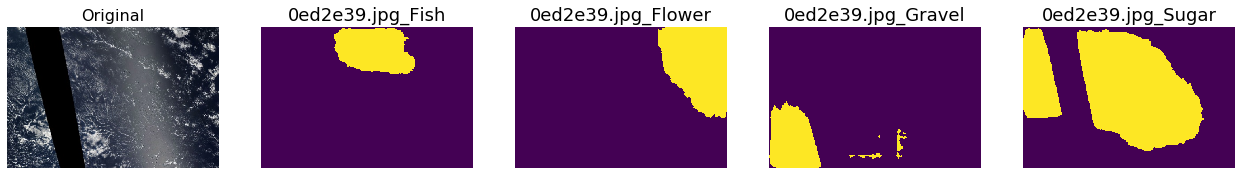

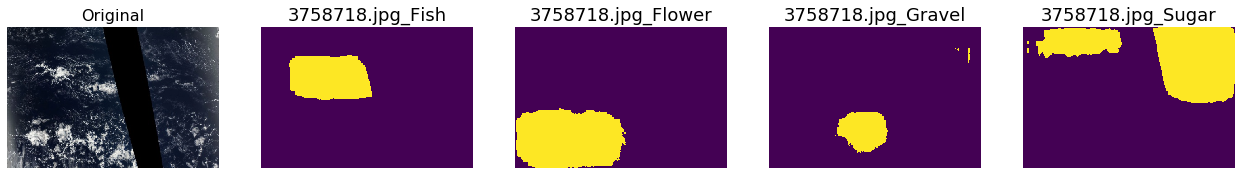

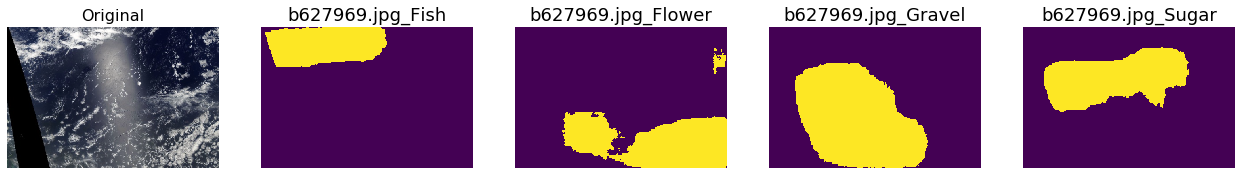

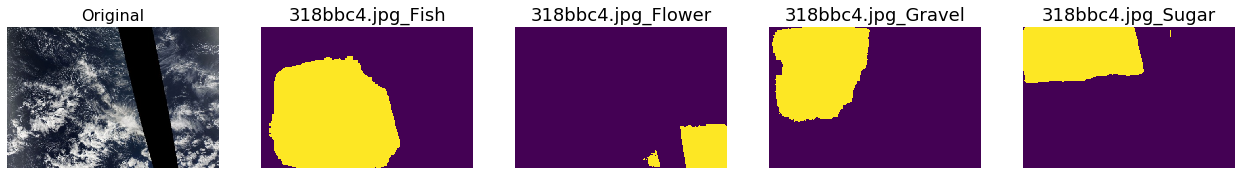

In [18]:
images_to_inspect_test =  np.random.choice(submission['image'].unique(), 4, replace=False)
inspect_predictions(submission, images_to_inspect_test, test_images_path)

### With post-process

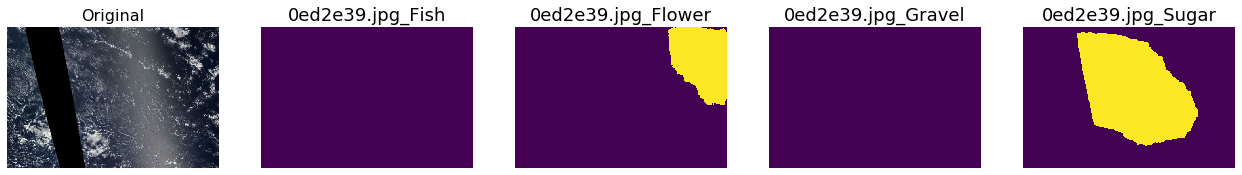

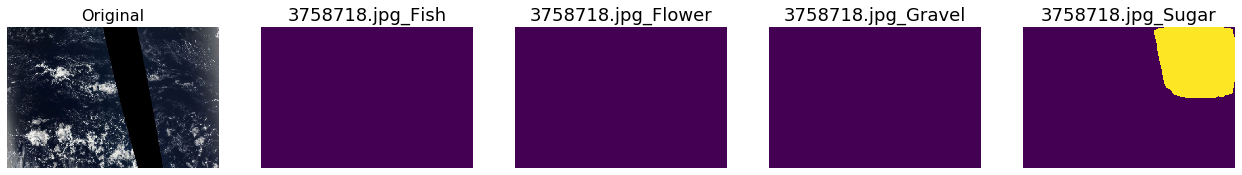

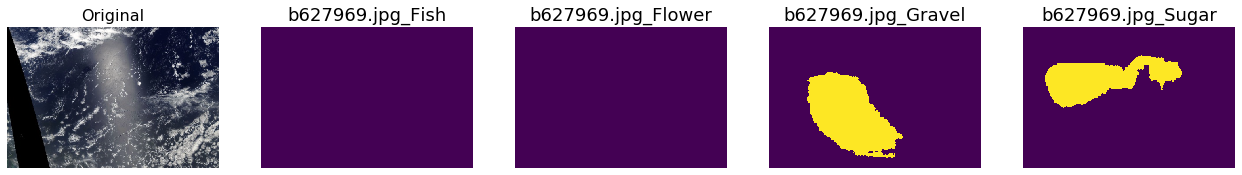

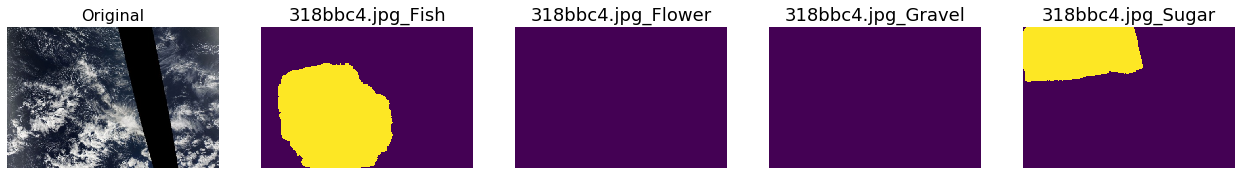

In [19]:
inspect_predictions(submission, images_to_inspect_test, test_images_path, label_col='EncodedPixels_post')

### With post-process non-empty masks

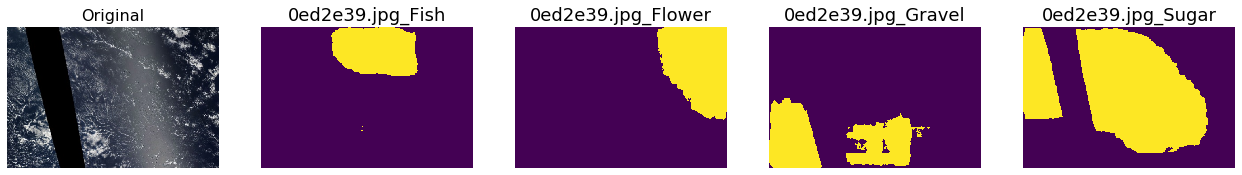

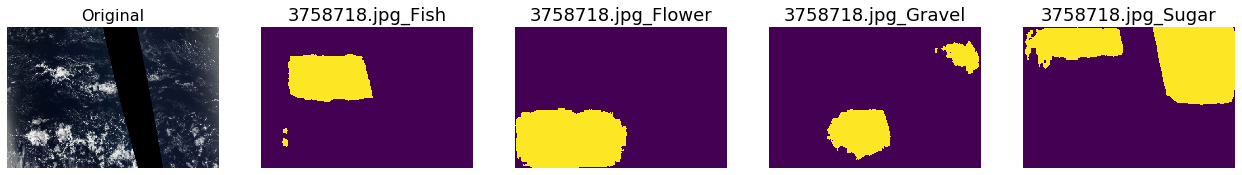

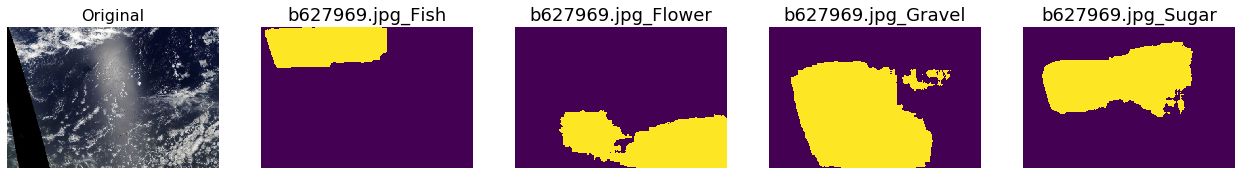

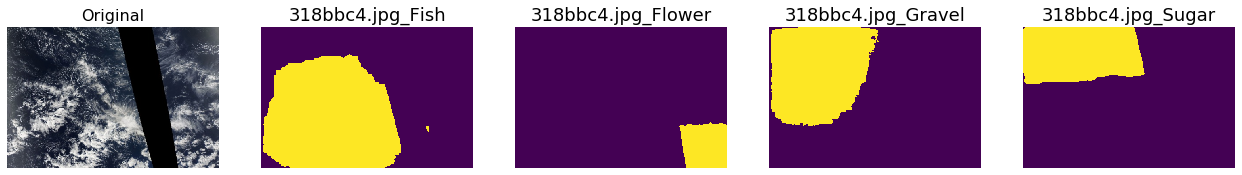

In [20]:
inspect_predictions(submission, images_to_inspect_test, test_images_path, label_col='EncodedPixels_post2')

### With post-process and mask classification

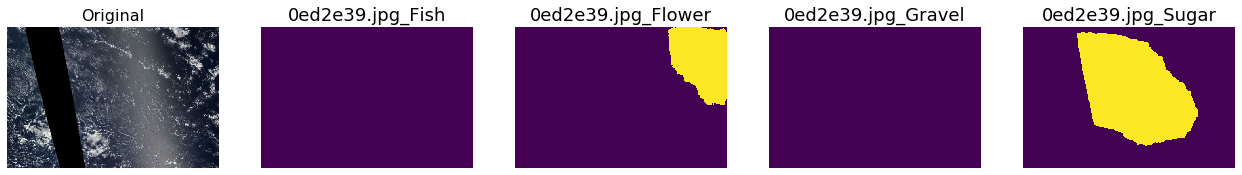

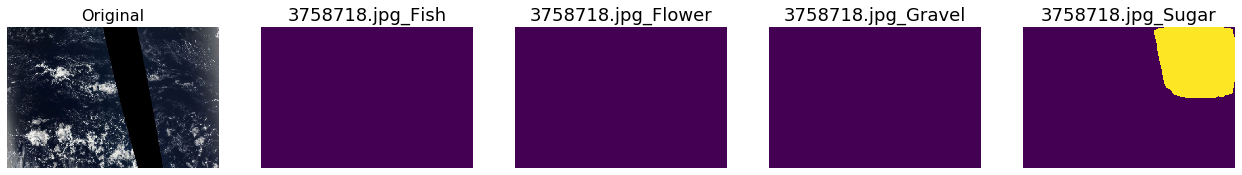

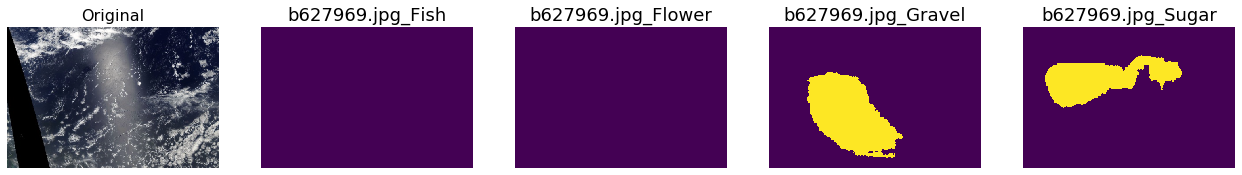

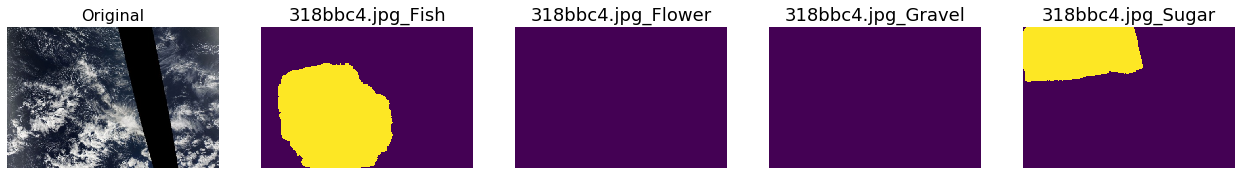

In [21]:
inspect_predictions(submission, images_to_inspect_test, test_images_path, label_col='EncodedPixels_post_class')

### With post-process non-empty masks and mask classification

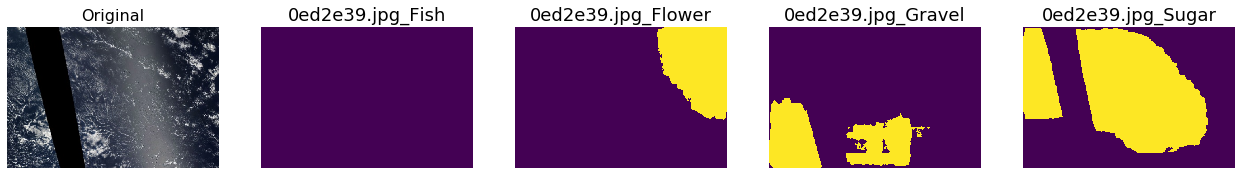

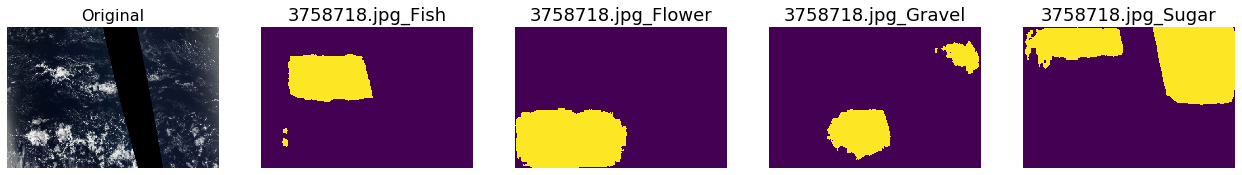

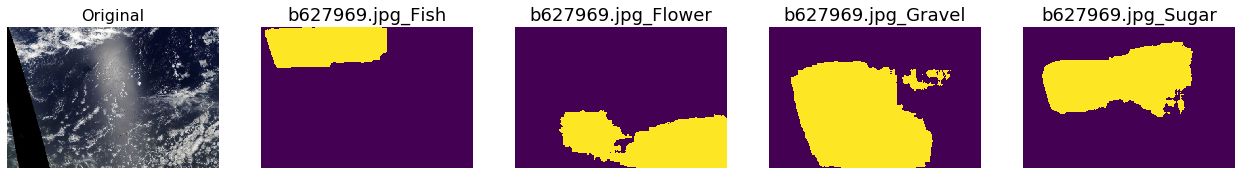

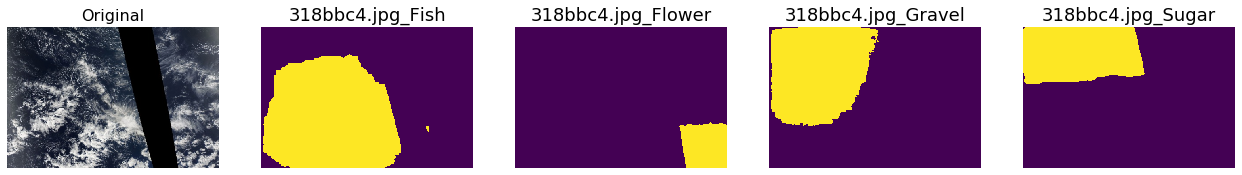

In [22]:
inspect_predictions(submission, images_to_inspect_test, test_images_path, label_col='EncodedPixels_post2_class')

### Without post-process and TTA

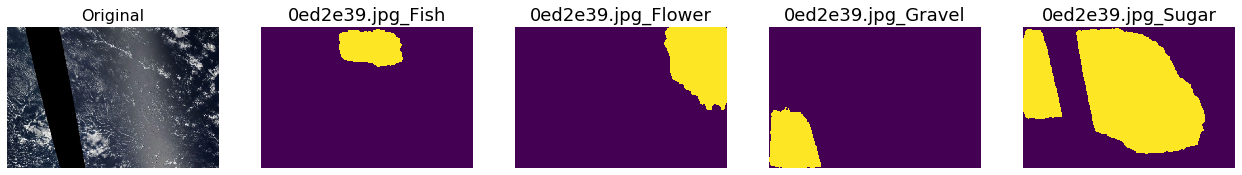

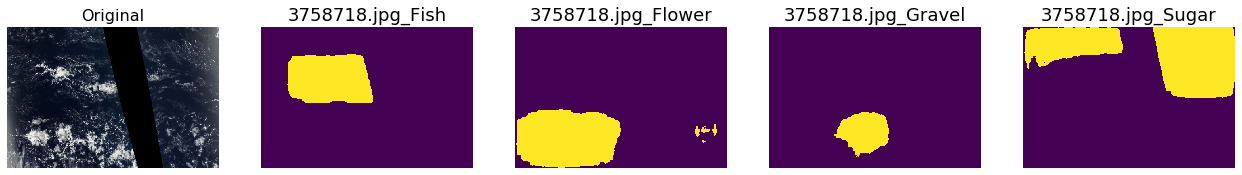

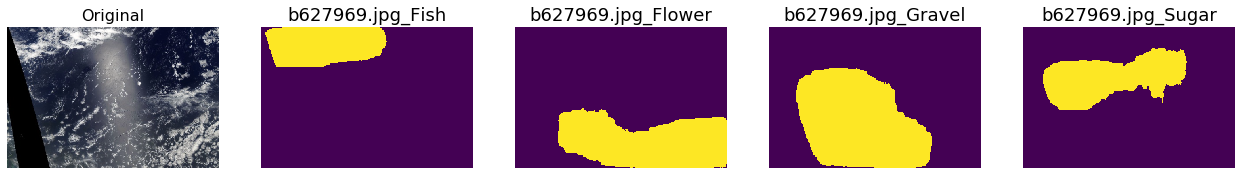

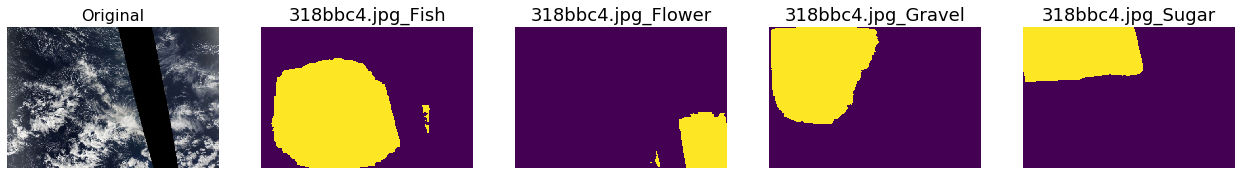

In [23]:
inspect_predictions(submission, images_to_inspect_test, test_images_path, label_col='EncodedPixels_tta')

### With post-process and TTA

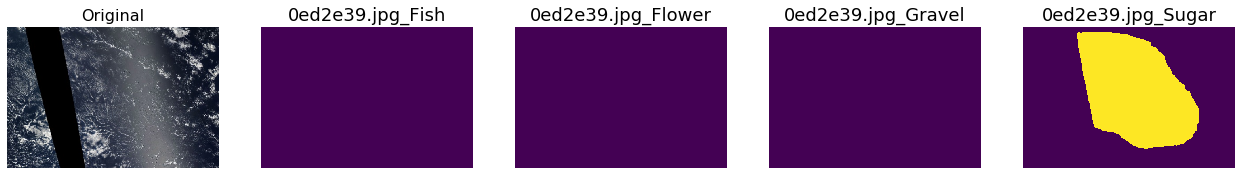

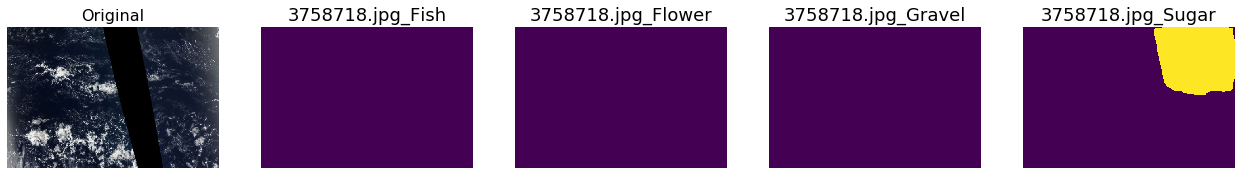

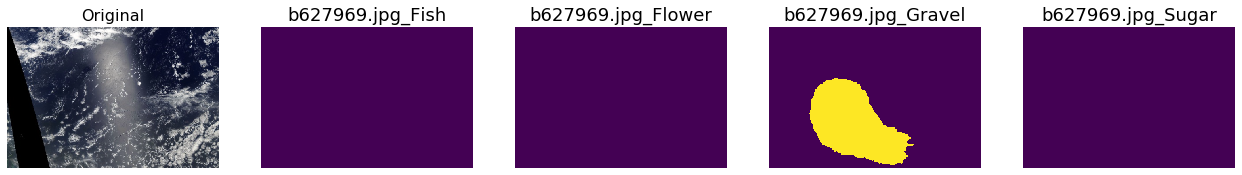

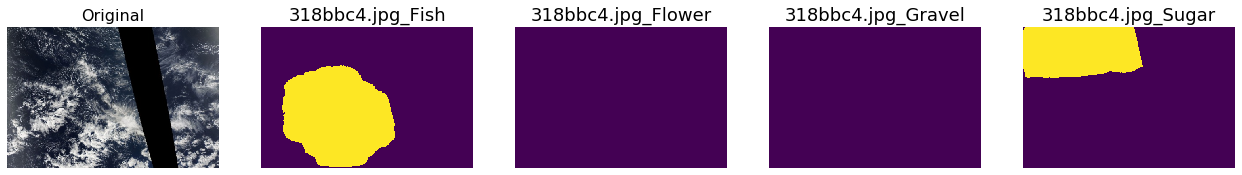

In [24]:
inspect_predictions(submission, images_to_inspect_test, test_images_path, label_col='EncodedPixels_post_tta')

### With post-process non-empty and TTA

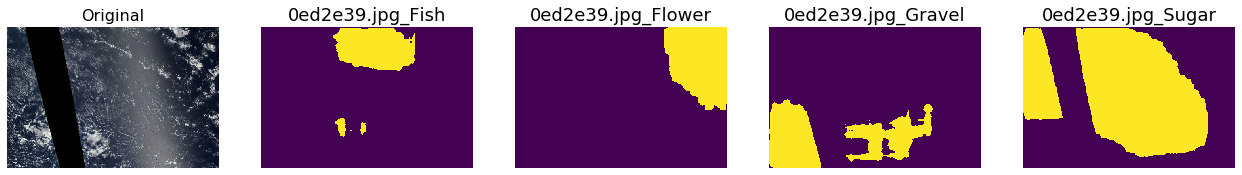

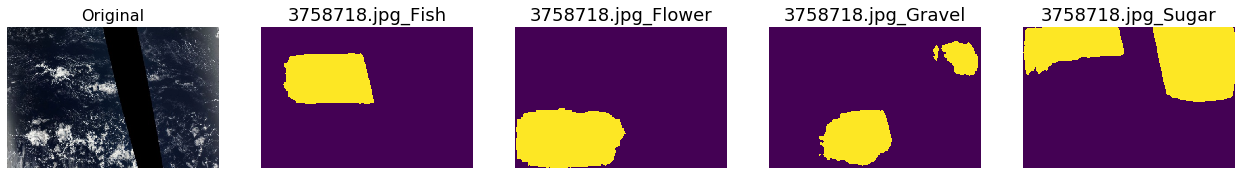

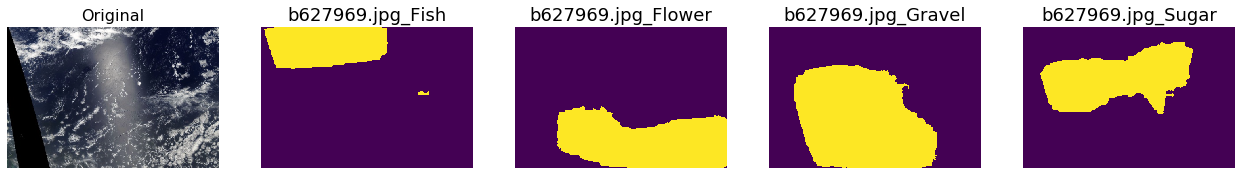

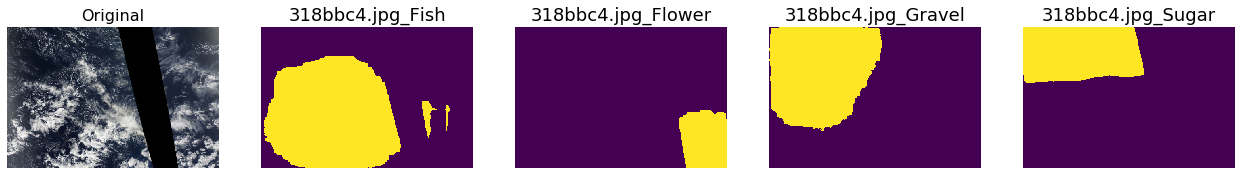

In [25]:
inspect_predictions(submission, images_to_inspect_test, test_images_path, label_col='EncodedPixels_post2_tta')

### With post-process and mask classification and mask classification

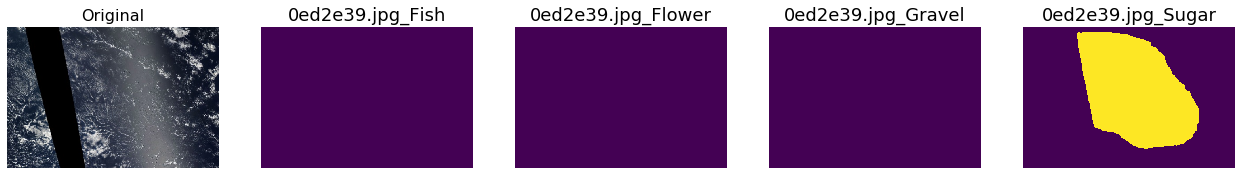

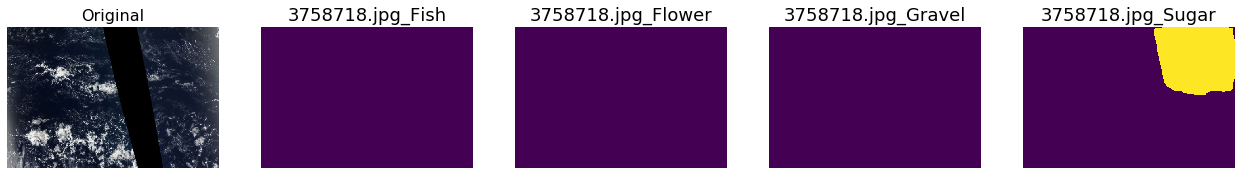

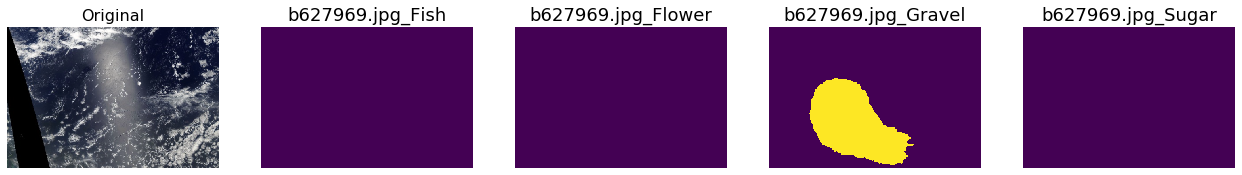

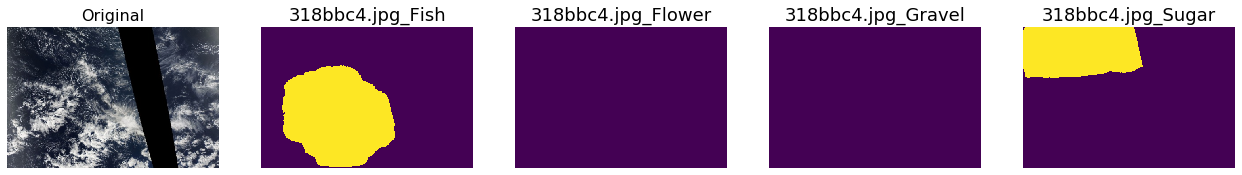

In [26]:
inspect_predictions(submission, images_to_inspect_test, test_images_path, label_col='EncodedPixels_post_class_tta')

### With post-process non-empty and mask classification and mask classification

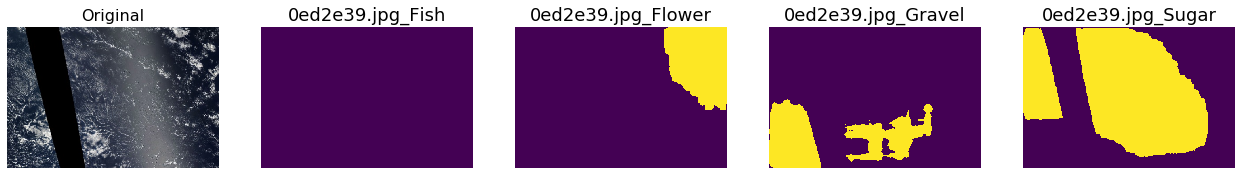

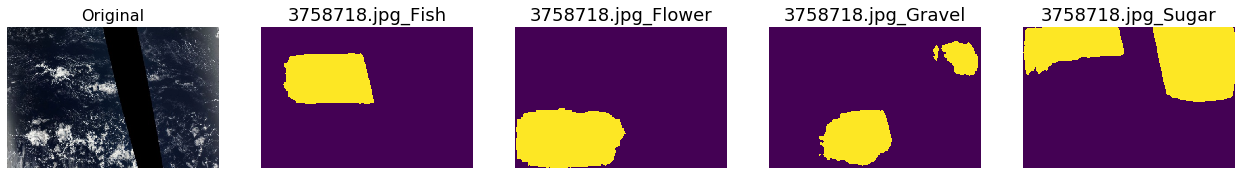

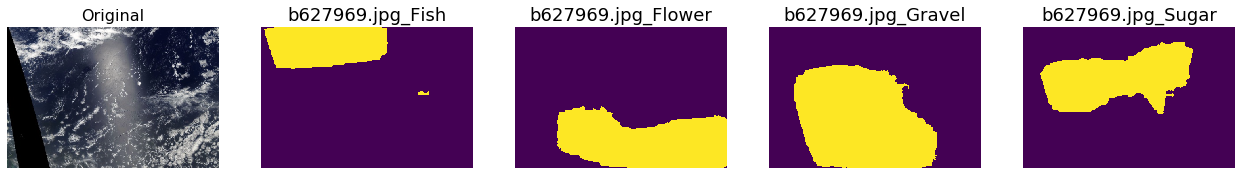

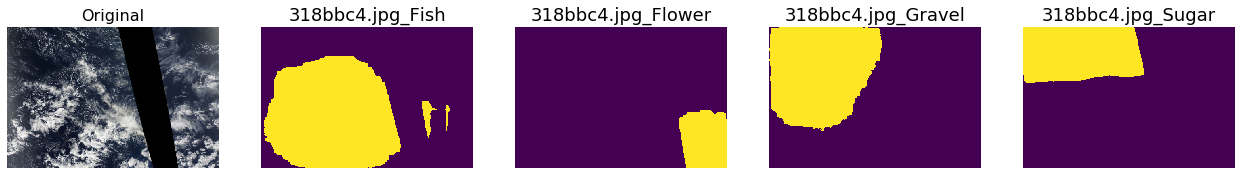

In [27]:
inspect_predictions(submission, images_to_inspect_test, test_images_path, label_col='EncodedPixels_post2_class_tta')

### Regular submission

In [33]:
submission_df = submission[['Image_Label' ,'EncodedPixels']]
submission_df.to_csv(submission_path, index=False)
display(submission_df.head())

Image_Label                                      EncodedPixels
0    002f507.jpg_Fish  33132 7 33142 5 33154 1 33481 24 33830 25 3417...
1  002f507.jpg_Flower  47657 1 47995 7 48004 10 48328 39 48672 51 490...
2  002f507.jpg_Gravel  18 24 45 188 243 2 257 32 301 7 310 2 368 24 3...
3   002f507.jpg_Sugar  1876 2 1900 16 1925 4 2211 80 2520 2 2559 84 2...
4    0035ae9.jpg_Fish  50449 2 50797 6 51146 8 51496 9 51524 7 51845 ...

### Submission with post processing

In [34]:
submission_df = submission[['Image_Label' ,'EncodedPixels_post']]
submission_df.columns = ['Image_Label' ,'EncodedPixels']
submission_df.to_csv(submission_post_path, index=False)
display(submission_df.head())

Image_Label                                      EncodedPixels
0    002f507.jpg_Fish                                                   
1  002f507.jpg_Flower                                                   
2  002f507.jpg_Gravel  1097 184 1422 210 1644 3 1660 22 1684 2 1771 2...
3   002f507.jpg_Sugar  3302 2 3308 2 3651 10 3681 2 3997 36 4347 36 4...
4    0035ae9.jpg_Fish  63396 1 63746 3 64096 3 64446 3 64795 4 65144 ...

### Submission with post processing non-empty masks 

In [35]:
submission_df = submission[['Image_Label' ,'EncodedPixels_post2']]
submission_df.columns = ['Image_Label' ,'EncodedPixels']
submission_df.to_csv(submission_post2_path, index=False)
display(submission_df.head())

Image_Label                                      EncodedPixels
0    002f507.jpg_Fish  30004 5 30349 12 30686 27 31031 34 31380 37 31...
1  002f507.jpg_Flower  46958 2 46962 1 47280 1 47299 1 47304 9 47625 ...
2  002f507.jpg_Gravel  10 225 241 80 360 225 591 80 706 231 940 93 10...
3   002f507.jpg_Sugar  1521 2 1526 2 1552 15 1577 2 1813 14 1835 2 18...
4    0035ae9.jpg_Fish  45225 3 45574 5 45924 6 46273 8 46622 14 46957...

### Submission with post processing and mask classification

In [36]:
submission_df = submission[['Image_Label' ,'EncodedPixels_post_class']]
submission_df.columns = ['Image_Label' ,'EncodedPixels']
submission_df.to_csv(submission_post_class_path, index=False)
display(submission_df.head())

Image_Label                                      EncodedPixels
0    002f507.jpg_Fish                                                   
1  002f507.jpg_Flower                                                   
2  002f507.jpg_Gravel  1097 184 1422 210 1644 3 1660 22 1684 2 1771 2...
3   002f507.jpg_Sugar  3302 2 3308 2 3651 10 3681 2 3997 36 4347 36 4...
4    0035ae9.jpg_Fish  63396 1 63746 3 64096 3 64446 3 64795 4 65144 ...

### Submission with post processing non-empty masks and mask classification

In [37]:
submission_df = submission[['Image_Label' ,'EncodedPixels_post2_class']]
submission_df.columns = ['Image_Label' ,'EncodedPixels']
submission_df.to_csv(submission_post2_class_path, index=False)
display(submission_df.head())

Image_Label                                      EncodedPixels
0    002f507.jpg_Fish  30004 5 30349 12 30686 27 31031 34 31380 37 31...
1  002f507.jpg_Flower                                                   
2  002f507.jpg_Gravel  10 225 241 80 360 225 591 80 706 231 940 93 10...
3   002f507.jpg_Sugar  1521 2 1526 2 1552 15 1577 2 1813 14 1835 2 18...
4    0035ae9.jpg_Fish  45225 3 45574 5 45924 6 46273 8 46622 14 46957...

### Submission without post processing and TTA

In [38]:
submission_df = submission[['Image_Label' ,'EncodedPixels_tta']]
submission_df.columns = ['Image_Label' ,'EncodedPixels']
submission_df.to_csv(submission_tta_path, index=False)
display(submission_df.head())

Image_Label                                      EncodedPixels
0    002f507.jpg_Fish  39431 4 39774 2 39778 9 40124 15 40472 18 4049...
1  002f507.jpg_Flower  46947 4 47295 13 47311 1 47642 21 47978 39 483...
2  002f507.jpg_Gravel  8 225 241 84 358 225 591 84 706 229 940 91 105...
3   002f507.jpg_Sugar  1904 5 1911 1 2227 1 2232 3 2244 24 2271 9 257...
4    0035ae9.jpg_Fish  60975 13 61325 13 61672 18 62018 33 62362 42 6...

### Submission with post processing and TTA

In [39]:
submission_df = submission[['Image_Label' ,'EncodedPixels_post_tta']]
submission_df.columns = ['Image_Label' ,'EncodedPixels']
submission_df.to_csv(submission_post_tta_path, index=False)
display(submission_df.head())

Image_Label                                      EncodedPixels
0    002f507.jpg_Fish                                                   
1  002f507.jpg_Flower                                                   
2  002f507.jpg_Gravel  756 83 852 20 874 8 895 1 898 8 1082 198 1311 ...
3   002f507.jpg_Sugar                                                   
4    0035ae9.jpg_Fish

### Submission with post processing non-empty masks and TTA

In [40]:
submission_df = submission[['Image_Label' ,'EncodedPixels_post2_tta']]
submission_df.columns = ['Image_Label' ,'EncodedPixels']
submission_df.to_csv(submission_post2_tta_path, index=False)
display(submission_df.head())

Image_Label                                      EncodedPixels
0    002f507.jpg_Fish  31400 9 31747 13 32092 20 32432 31 32782 31 33...
1  002f507.jpg_Flower  45880 1 46229 4 46247 3 46579 5 46593 11 46607...
2  002f507.jpg_Gravel  1 334 351 334 701 341 1051 344 1401 345 1751 3...
3   002f507.jpg_Sugar  1204 4 1210 7 1521 11 1535 4 1548 33 1860 83 2...
4    0035ae9.jpg_Fish  54690 5 55025 5 55035 11 55373 25 55720 29 560...

### Submission with post processing and TTA and mask classification

In [41]:
submission_df = submission[['Image_Label' ,'EncodedPixels_post_class_tta']]
submission_df.columns = ['Image_Label' ,'EncodedPixels']
submission_df.to_csv(submission_post_class_tta_path, index=False)
display(submission_df.head())

Image_Label                                      EncodedPixels
0    002f507.jpg_Fish                                                   
1  002f507.jpg_Flower                                                   
2  002f507.jpg_Gravel  756 83 852 20 874 8 895 1 898 8 1082 198 1311 ...
3   002f507.jpg_Sugar                                                   
4    0035ae9.jpg_Fish

### Submission with post processing non-empty masks and TTA and mask classification

In [42]:
submission_df = submission[['Image_Label' ,'EncodedPixels_post2_class_tta']]
submission_df.columns = ['Image_Label' ,'EncodedPixels']
submission_df.to_csv(submission_post2_class_tta_path, index=False)
display(submission_df.head())

Image_Label                                      EncodedPixels
0    002f507.jpg_Fish  31400 9 31747 13 32092 20 32432 31 32782 31 33...
1  002f507.jpg_Flower                                                   
2  002f507.jpg_Gravel  1 334 351 334 701 341 1051 344 1401 345 1751 3...
3   002f507.jpg_Sugar  1204 4 1210 7 1521 11 1535 4 1548 33 1860 83 2...
4    0035ae9.jpg_Fish  54690 5 55025 5 55035 11 55373 25 55720 29 560...